In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)
print(class_names)

{'train': 41, 'val': 10}
['mask', 'no_mask']


In [4]:
def imshow(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    plt.imshow(input)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


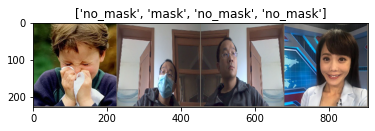

In [5]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def save_model(model, model_name):
    torch.save(model, "{}.pth".format(model_name))

    example = torch.rand(1, 3, 224, 224).to(device)
    # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
    traced_script_module = torch.jit.trace(model, example)
    traced_script_module.save("{}.pt".format(model_name))

In [9]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.Adam(model_ft.parameters())
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                      exp_lr_scheduler, num_epochs=30)

save_model(model_ft, "model_ft")

Epoch 0/29
----------
train Loss: 0.8290 Acc: 0.4878
val Loss: 0.6480 Acc: 0.5000

Epoch 1/29
----------
train Loss: 1.2263 Acc: 0.4146
val Loss: 0.8230 Acc: 0.5000

Epoch 2/29
----------
train Loss: 0.8999 Acc: 0.6098
val Loss: 0.6343 Acc: 0.6000

Epoch 3/29
----------
train Loss: 0.7836 Acc: 0.6341
val Loss: 0.4351 Acc: 0.7000

Epoch 4/29
----------
train Loss: 0.4039 Acc: 0.7805
val Loss: 0.2408 Acc: 0.9000

Epoch 5/29
----------
train Loss: 0.4036 Acc: 0.7805
val Loss: 0.3656 Acc: 0.9000

Epoch 6/29
----------
train Loss: 0.5708 Acc: 0.6341
val Loss: 0.4680 Acc: 0.6000

Epoch 7/29
----------
train Loss: 0.7583 Acc: 0.6829
val Loss: 0.4038 Acc: 0.6000

Epoch 8/29
----------
train Loss: 0.4393 Acc: 0.7317
val Loss: 0.2188 Acc: 0.9000

Epoch 9/29
----------
train Loss: 0.2645 Acc: 0.8780
val Loss: 0.3665 Acc: 0.9000

Epoch 10/29
----------
train Loss: 0.2365 Acc: 0.9024
val Loss: 0.2408 Acc: 0.9000

Epoch 11/29
----------
train Loss: 0.2771 Acc: 0.9024
val Loss: 0.2053 Acc: 0.9000

Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


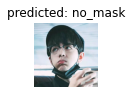

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


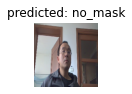

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


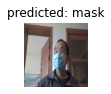

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [11]:
visualize_model(model_ft)

In [12]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#optimizer_conv = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

save_model(model_conv, "model_conv")

Epoch 0/29
----------
train Loss: 0.7518 Acc: 0.4390
val Loss: 0.6173 Acc: 0.8000

Epoch 1/29
----------
train Loss: 0.7426 Acc: 0.5122
val Loss: 0.4603 Acc: 0.9000

Epoch 2/29
----------
train Loss: 0.6024 Acc: 0.6585
val Loss: 0.5048 Acc: 0.7000

Epoch 3/29
----------
train Loss: 0.6294 Acc: 0.6098
val Loss: 0.2931 Acc: 0.9000

Epoch 4/29
----------
train Loss: 0.5021 Acc: 0.7073
val Loss: 0.2609 Acc: 1.0000

Epoch 5/29
----------
train Loss: 0.2891 Acc: 0.9024
val Loss: 0.2577 Acc: 0.9000

Epoch 6/29
----------
train Loss: 0.3666 Acc: 0.8780
val Loss: 0.2996 Acc: 1.0000

Epoch 7/29
----------
train Loss: 0.4879 Acc: 0.7073
val Loss: 0.2419 Acc: 1.0000

Epoch 8/29
----------
train Loss: 0.4165 Acc: 0.8537
val Loss: 0.2069 Acc: 0.9000

Epoch 9/29
----------
train Loss: 0.2884 Acc: 0.9024
val Loss: 0.2286 Acc: 0.9000

Epoch 10/29
----------
train Loss: 0.4251 Acc: 0.7805
val Loss: 0.2688 Acc: 0.9000

Epoch 11/29
----------
train Loss: 0.2715 Acc: 0.9024
val Loss: 0.2053 Acc: 0.9000

Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


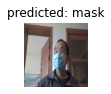

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


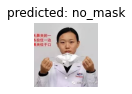

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


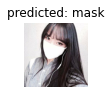

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


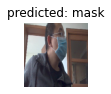

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


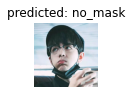

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [14]:
visualize_model(model_conv)

In [15]:
plt.ioff()
plt.show()

In [21]:
from jetcam.laptop_camera import LaptopCamera
camera = LaptopCamera(width=224, height=224)

camera.running = True
print("camera created")

camera created


In [22]:
import ipywidgets
import traitlets
from IPython.display import display
from jetcam.utils import bgr8_to_jpeg
import torch.nn.functional as F
import threading
import time
import PIL.Image

camera.unobserve_all()

# create image preview
camera_widget = ipywidgets.Image()
traitlets.dlink((camera, 'value'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

camera_box = ipywidgets.VBox([camera_widget])

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()

def preprocess(image):
    device = torch.device('cuda')
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

In [23]:
model = model_conv

state_widget = ipywidgets.ToggleButtons(options=['stop', 'live'], description='state', value='stop')
prediction_widget = ipywidgets.Text(description='prediction')
score_widgets = []
for category in class_names:
    score_widget = ipywidgets.FloatSlider(min=0.0, max=1.0, description=category, orientation='vertical')
    score_widgets.append(score_widget)
    
def live(state_widget, model, camera, prediction_widget, score_widget):
    while state_widget.value == 'live':
        image = camera.value
        preprocessed = preprocess(image)
        output = model(preprocessed)
        output = F.softmax(output, dim=1).detach().cpu().numpy().flatten()
        category_index = output.argmax()
        prediction_widget.value = class_names[category_index]
        for i, score in enumerate(list(output)):
            score_widgets[i].value = score
            
def start_live(change):
    if change['new'] == 'live':
        execute_thread = threading.Thread(target=live, args=(state_widget, model, camera, prediction_widget, score_widget))
        execute_thread.start()

state_widget.observe(start_live, names='value')

live_execution_widget = ipywidgets.VBox([
    ipywidgets.HBox(score_widgets),
    prediction_widget,
    state_widget
])

#display(live_execution_widget)

In [24]:
all_widget = ipywidgets.HBox([camera_box, live_execution_widget])
display(all_widget)

In [25]:
camera.cap.release()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/xyz/anaconda3/envs/torch/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/xyz/anaconda3/envs/torch/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xyz/anaconda3/envs/torch/lib/python3.7/site-packages/jetcam-0.0.0-py3.7.egg/jetcam/camera.py", line 34, in _capture_frames
    self.value = self._read()
  File "/home/xyz/anaconda3/envs/torch/lib/python3.7/site-packages/jetcam-0.0.0-py3.7.egg/jetcam/laptop_camera.py", line 41, in _read
    raise RuntimeError('Could not read image from camera')
RuntimeError: Could not read image from camera

